In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import imageio
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
from IPython.display import display, Image
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch.nn.functional as F
import torch
import yaml
import lpips
import collections

import scipy.signal

import sys
import os
sys.path.append(str(Path(os.path.abspath('')).parent))
from modules.tonemap import SRGBTonemap

import lpips

def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im)
    plt.close()
    display(fig.figure)

def merge_dicts(*dicts):
    res = dict()
    for d in dicts:
        for k, v in d.items():
            res[k] = v
    return res

def rgb_ssim(img0, img1, max_val,
             filter_size=11,
             filter_sigma=1.5,
             k1=0.01,
             k2=0.03,
             return_map=False):
    # Modified from https://github.com/google/mipnerf/blob/16e73dfdb52044dcceb47cda5243a686391a6e0f/internal/math.py#L58
    assert len(img0.shape) == 3
    assert img0.shape[-1] == 3
    assert img0.shape == img1.shape

    # Construct a 1D Gaussian blur filter.
    hw = filter_size // 2
    shift = (2 * hw - filter_size + 1) / 2
    f_i = ((np.arange(filter_size) - hw + shift) / filter_sigma)**2
    filt = np.exp(-0.5 * f_i)
    filt /= np.sum(filt)

    # Blur in x and y (faster than the 2D convolution).
    def convolve2d(z, f):
        return scipy.signal.convolve2d(z, f, mode='valid')

    filt_fn = lambda z: np.stack([
        convolve2d(convolve2d(z[...,i], filt[:, None]), filt[None, :])
        for i in range(z.shape[-1])], -1)
    mu0 = filt_fn(img0)
    mu1 = filt_fn(img1)
    mu00 = mu0 * mu0
    mu11 = mu1 * mu1
    mu01 = mu0 * mu1
    sigma00 = filt_fn(img0**2) - mu00
    sigma11 = filt_fn(img1**2) - mu11
    sigma01 = filt_fn(img0 * img1) - mu01

    # Clip the variances and covariances to valid values.
    # Variance must be non-negative:
    sigma00 = np.maximum(0., sigma00)
    sigma11 = np.maximum(0., sigma11)
    sigma01 = np.sign(sigma01) * np.minimum(
        np.sqrt(sigma00 * sigma11), np.abs(sigma01))
    c1 = (k1 * max_val)**2
    c2 = (k2 * max_val)**2
    numer = (2 * mu01 + c1) * (2 * sigma01 + c2)
    denom = (mu00 + mu11 + c1) * (sigma00 + sigma11 + c2)
    ssim_map = numer / denom
    ssim = np.mean(ssim_map)
    return ssim_map if return_map else ssim

device = torch.device('cuda')
loss_fn_alex = lpips.LPIPS(net='alex').to(device)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [3]:

exps = ["relighting"]#, 'fixedmip128', 'tensorf', 'singlebounce_samen']
base_path = Path("/optane/nerf_datasets/nerf_synthetic/relighting/")
for exp in exps:
    log_dir = Path("../log") / exp
    for p in log_dir.glob("*"):
        print(p)
        config = OmegaConf.load(p / 'config.yaml')
        new_data_path = p / "imgs_test_ori" / "stats.yaml"

        dname = Path(config['dataset']['scenedir']).name
        if dname != 'toaster':
            continue
        dname2 = dname.split("_")[0] + "_christmas"

        gt_p = base_path / dname2

        # load all images
        pred_ims = []
        gt_ims = []
        for i in range(200):
            # im_p1 = p / "imgs_test_all" / f'{i:03d}.exr'
            im_p1 = p / "imgs_test_ori" / f'{i:03d}.exr'
            im1 = imageio.imread(im_p1)
            pred_ims.append(im1)
            im_p2 = gt_p / 'test' / f'r_{i}.exr'
            im2 = imageio.imread(im_p2)
            gt_ims.append(im2)

        means = []
        for i in range(200):
            mask = (gt_ims[i][..., 3] > 0.5) & (pred_ims[i].min(axis=-1) > 0.01)
            means.append(np.mean((gt_ims[i][mask, :3]/pred_ims[i][mask].clip(min=1e-7)), axis=0))
        multi = sum(means)/len(means)
        print(multi)
        # compute a global brightness multiplier
        tm = SRGBTonemap()
        adjusted_preds = []
        psnrs = []
        ssims = []
        lpips_vs = []
        for i in range(200):
            acc = gt_ims[i][..., 3:4]
            ap = pred_ims[i] *multi.reshape(1, 1, 3) * acc + (1-acc)
            tpred = tm(torch.as_tensor(ap)).clip(min=0, max=1)
            tgt = tm(torch.as_tensor(gt_ims[i][..., :3] + (1-acc))).clip(min=0, max=1)
            adjusted_preds.append(ap)
            # disp_im(tpred)
            # disp_im(tgt)

            pred_t = tpred.permute(2, 0, 1).unsqueeze(0).to(device)
            gt_t = tgt.permute(2, 0, 1).unsqueeze(0).to(device)
            err = (pred_t - gt_t)**2
            psnr = -10 * torch.log(torch.mean(err)) / np.log(10.0)
            psnrs.append(psnr.item())

            with torch.no_grad():
                lpips_v = loss_fn_alex(pred_t, gt_t, normalize=True).cpu()
            ssims.append(rgb_ssim(tpred, tgt, 1))
            lpips_vs.append(float(lpips_v))

        data = dict(psnr=float(sum(psnrs) / len(psnrs)), lpips=float(sum(lpips_vs) / len(lpips_vs)), ssim=float(sum(ssims) / len(ssims)))
        # print(p, data)
        with new_data_path.open('w') as f:
            yaml.dump(dict(data), f)


        print(p)
        print(f"PSNR: {float(sum(psnrs) / len(psnrs))}")
        print(f"LPIPS: {float(sum(lpips_vs) / len(lpips_vs))}")
        print(f"SSIMS: {float(sum(ssims) / len(ssims))}")

../log/relighting/ball_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more_nomin_8appdim_bigstep_olddiffvec


/tmp/ipykernel_3812566/1187696651.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imageio.imread(im_p1)
/tmp/ipykernel_3812566/1187696651.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im2 = imageio.imread(im_p2)


[2.2303796 2.1557143 2.9499936]
../log/relighting/ball_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more_nomin_8appdim_bigstep_olddiffvec
PSNR: 13.896497197151184
LPIPS: 0.3158430403470993
SSIMS: 0.8303444963634294
../log/relighting/car_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more_nomin_8appdim_bigstep_olddiffvec
[1.2449096 0.9863775 0.7813498]
../log/relighting/car_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more_nomin_8appdim_bigstep_olddiffvec
PSNR: 20.89425344467163
LPIPS: 0.07456720665097237
SSIMS: 0.8929620643053017
../log/relighting/helmet_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more
[0.918287   0.929511   0.97730464]
../log/relighting/helmet_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more
PSNR: 17.127989344596863
LPIPS: 0.18551584027707577
SSIMS: 0.8740038157147534
../log/relighting/coffee_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more_nomin_8appdim_bigstep_olddiffvec_fix
[1.055477  1.7424726 2.8157294]
../log/relighting

FileNotFoundError: No such file: '/home/dronelab/nmf/log/relighting/toaster_exr_v38_bglr0.08_0.5tint_nobright_nonormals_tonemap_more/imgs_test_ori/000.exr'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


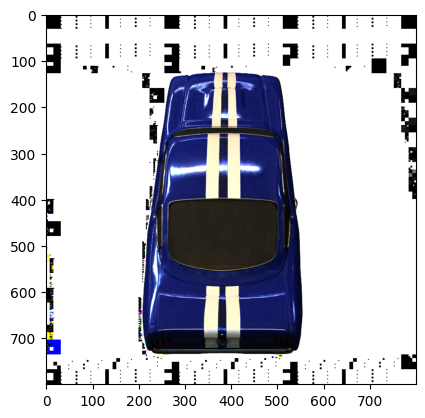

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


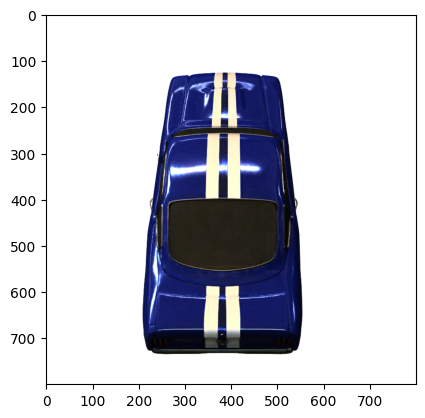

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


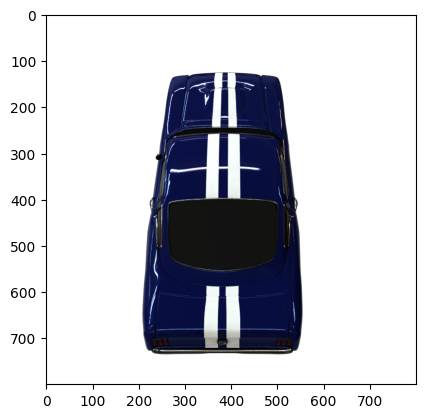

In [ ]:
disp_im(pred_ims[0]*multi.reshape(1, 1, 3))
disp_im(adjusted_preds[0])
disp_im(gt_ims[0])